In [1]:
# Import libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
from matplotlib import pyplot as plt
from scipy.stats import linregress

In [2]:
# Get the medal details dataset
df_medal_details = pd.read_csv('../data/etl/medals_by_type_game_country_season_discip_event_gender.csv')
df_medal_details.head()

,game_name,country_name,game_season,discipline_title,event_title,event_gender,gold,silver,bronze,total_medals
0,Albertville 1992,Austria,Winter,Alpine Skiing,alpine combined women,Women,1.0,1.0,NaN,2.0
1,Albertville 1992,Austria,Winter,Alpine Skiing,downhill men,Men,1.0,NaN,1.0,2.0
2,Albertville 1992,Austria,Winter,Alpine Skiing,downhill women,Women,NaN,NaN,1.0,1.0
3,Albertville 1992,Austria,Winter,Alpine Skiing,giant slalom women,Women,NaN,1.0,NaN,1.0
4,Albertville 1992,Austria,Winter,Alpine Skiing,slalom men,Men,NaN,NaN,1.0,1.0


In [3]:
# Get all of the other datasets in the etl folder
df_hapiness = pd.read_csv('../data/etl/happiness_avg_by_country.csv')
df_gdp = pd.read_csv('../data/etl/gdp_avg_by_country.csv')
df_nutrition = pd.read_csv('../data/etl/nutrition_2017_by_country.csv')
df_nutrition.head()


,country_code,country_name,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
0,ABW,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.361
1,AGO,Angola,57.2,87.1,7.1,92.9,17.0,26.0,27.7,29816.769
2,AIA,Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALB,Albania,0.0,13.0,62.2,37.8,0.0,0.4,1.1,2873.457
4,ARE,United Arab Emirates,0.0,0.0,NaN,0.0,0.0,0.0,0.0,9487.206


In [4]:
# Unwanted columns - Simplify the dataset
unwanted_cols = [
    'support',
    'health',
    'freedom',
    'generosity',
    'corruption',
    'positivity',
    'negativity',
    'calories_pct',
    'nutrients_pct',
    'calories_mills',
    'nutrients_mills',
    'diet_mills'
]

In [5]:
# Function to merge a medals slice with the other datasets
def merge_hap_gdp_nut(df_medal_slice: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(df_medal_slice, df_hapiness, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_gdp, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_nutrition, on='country_name', how='left')
    df_merged = df_merged.drop(columns=['country_code']).reset_index(drop=True)
    df_merged.drop(unwanted_cols, axis=1, inplace=True)
    return df_merged

In [6]:
# Function to slice the medal details dataset and prepare it for correlation
def slice_medal_details_data(data_to_select: dict[str, str]) -> pd.DataFrame:
    drop_medal_cols = ['game_season', 'discipline_title', 'event_title', 'event_gender', 'gold', 'silver', 'bronze']
    group_medal_cols = ['country_name']

    df_slice = df_medal_details.copy()
    for key, value in data_to_select.items():
        df_slice = df_slice[df_slice[key] == value]

    df_slice = df_slice.drop(columns=drop_medal_cols)
    df_slice = df_slice.groupby(group_medal_cols)['total_medals'].sum().reset_index()
    return df_slice.reset_index(drop=True)

In [7]:
def box_plot_medals(df: pd.DataFrame, title: str) -> None:
    medals = df['total_medals']
    fig1, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.set_ylabel('Total Medals')
    ax1.boxplot(medals)
    plt.show()

In [40]:
def scatter_plot_medals(df: pd.DataFrame, x_col: str, y_col: str, title: str) -> None:
    df_plot = df.dropna()
    x_values = df_plot[x_col]
    y_values = df_plot[y_col]
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    plt.title(title)
    plt.scatter(x_values, y_values)
    plt.grid(True)
    plt.plot(x_values, regress_values, "r-")
    plt.xlabel(f'{x_col.replace("_", " ").title()}')
    plt.ylabel(f'{y_col.replace("_", " ").title()}')
    plt.show()    
    print(f"The r-squared is: {rvalue**2}")

In [42]:
# Women's summer games correlation
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
total_medals,1.000000,0.234169,0.292613,0.831738,0.287825,-0.269807,0.313934
happiness,0.234169,1.000000,0.802930,0.208903,0.745038,-0.729592,-0.178541
wealth,0.292613,0.802930,1.000000,0.228058,0.897316,-0.890775,-0.159272
gdp_avg,0.831738,0.208903,0.228058,1.000000,0.210865,-0.197154,0.409605
good_diet_pct,0.287825,0.745038,0.897316,0.210865,1.000000,-1.000000,-0.151061
bad_diet_pct,-0.269807,-0.729592,-0.890775,-0.197154,-1.000000,1.000000,0.159740
population,0.313934,-0.178541,-0.159272,0.409605,-0.151061,0.159740,1.000000


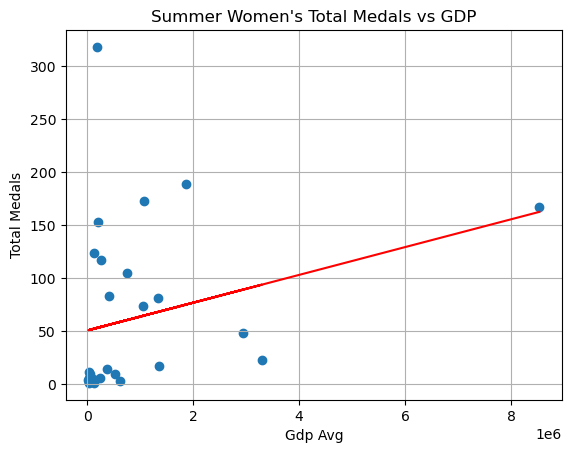

The r-squared is: 0.08006916801528824


In [57]:
# Scater plot of total_medals vs gdp_avg
scatter_plot_medals(df, 'gdp_avg', 'total_medals', 'Summer Women\'s Total Medals vs GDP')


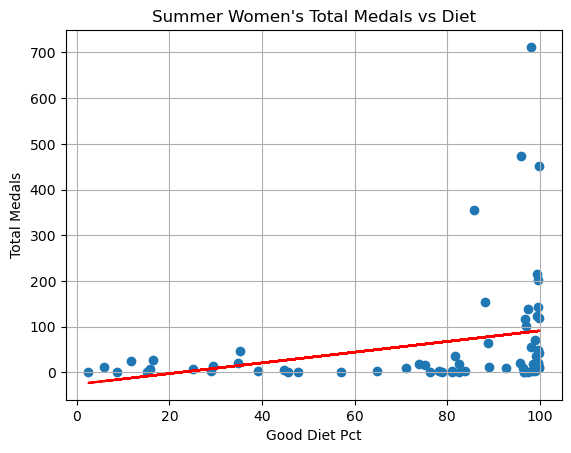

The r-squared is: 0.0812287172413686


In [45]:
scatter_plot_medals(df, 'good_diet_pct', 'total_medals', 'Summer Women\'s Total Medals vs Diet')

In [47]:
# Top and Bottom Womens Summer Games
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='total_medals', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,United States,1793.0,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,Russia,992.0,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
2,Germany,793.0,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
3,Great Britain,617.0,6.889592,10.695583,1345386.44,99.5,0.5,66058.859
4,France,554.0,6.659597,10.681801,1332030.59,99.9,0.1,66918.020


,country_name,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
131,Iraq,1.0,4.774596,9.109163,70166.73,46.7,53.3,37552.789
132,Tonga,1.0,NaN,NaN,231.03,NaN,NaN,NaN
133,Togo,1.0,3.719667,7.550613,2674.59,NaN,NaN,7698.476
134,Mauritius,1.0,5.849597,9.976086,4751.99,85.2,14.8,1264.613
135,Sudan,1.0,4.378741,8.475512,21197.29,13.7,86.3,40813.398


In [48]:
# Men's summer games correlation
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Men'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
total_medals,1.000000,0.302195,0.323346,0.838378,0.335520,-0.318831,0.180862
happiness,0.302195,1.000000,0.825564,0.220894,0.765472,-0.756928,-0.125130
wealth,0.323346,0.825564,1.000000,0.219088,0.884786,-0.881313,-0.123776
gdp_avg,0.838378,0.220894,0.219088,1.000000,0.224338,-0.210609,0.421530
good_diet_pct,0.335520,0.765472,0.884786,0.224338,1.000000,-1.000000,-0.112098
bad_diet_pct,-0.318831,-0.756928,-0.881313,-0.210609,-1.000000,1.000000,0.121600
population,0.180862,-0.125130,-0.123776,0.421530,-0.112098,0.121600,1.000000


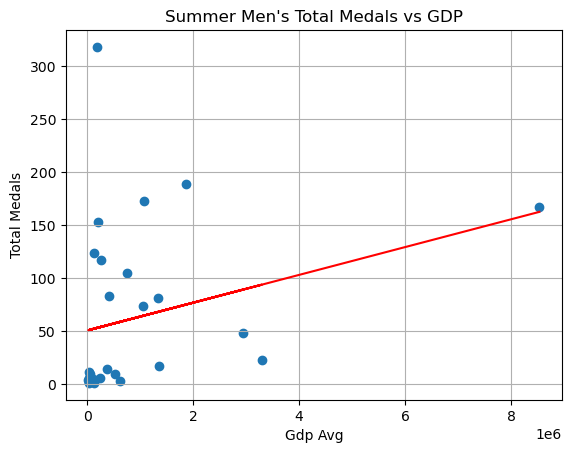

The r-squared is: 0.08006916801528824


In [58]:
scatter_plot_medals(df, 'gdp_avg', 'total_medals', 'Summer Men\'s Total Medals vs GDP')

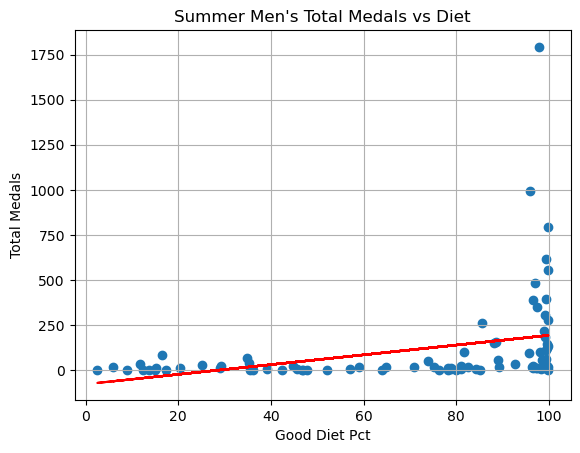

The r-squared is: 0.11102001522071282


In [49]:
scatter_plot_medals(df, 'good_diet_pct', 'total_medals', 'Summer Men\'s Total Medals vs Diet')

In [50]:
# Top and Bottom Mens Summer Games
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='total_medals', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,United States,1793.0,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,Russia,992.0,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
2,Germany,793.0,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
3,Great Britain,617.0,6.889592,10.695583,1345386.44,99.5,0.5,66058.859
4,France,554.0,6.659597,10.681801,1332030.59,99.9,0.1,66918.020


,country_name,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
131,Iraq,1.0,4.774596,9.109163,70166.73,46.7,53.3,37552.789
132,Tonga,1.0,NaN,NaN,231.03,NaN,NaN,NaN
133,Togo,1.0,3.719667,7.550613,2674.59,NaN,NaN,7698.476
134,Mauritius,1.0,5.849597,9.976086,4751.99,85.2,14.8,1264.613
135,Sudan,1.0,4.378741,8.475512,21197.29,13.7,86.3,40813.398


In [52]:
# Women's Winter games correlation
data_to_select = {
    'game_season': 'Winter', 
    'event_gender': 'Women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
total_medals,1.000000,0.293902,0.368509,0.497530,0.100702,-0.104417,0.141647
happiness,0.293902,1.000000,0.792075,0.025073,0.702636,-0.707371,-0.346490
wealth,0.368509,0.792075,1.000000,0.129109,0.718740,-0.719835,-0.528144
gdp_avg,0.497530,0.025073,0.129109,1.000000,-0.178119,0.185989,0.490593
good_diet_pct,0.100702,0.702636,0.718740,-0.178119,1.000000,-1.000000,-0.691285
bad_diet_pct,-0.104417,-0.707371,-0.719835,0.185989,-1.000000,1.000000,0.692564
population,0.141647,-0.346490,-0.528144,0.490593,-0.691285,0.692564,1.000000


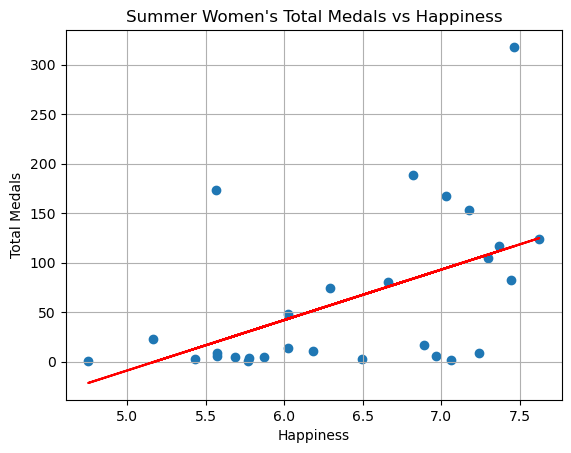

The r-squared is: 0.26642781498362755


In [56]:
scatter_plot_medals(df, 'happiness', 'total_medals', 'Summer Women\'s Total Medals vs Happiness')

In [59]:
# Top and Bottom Womens Winter Games
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='total_medals', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,Norway,318.0,7.463886,11.074348,186487.61,99.5,0.5,5276.968
1,Germany,189.0,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
2,Russia,173.0,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
3,United States,167.0,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
4,Austria,153.0,7.178953,10.889285,197169.69,99.4,0.6,8797.566


,country_name,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
33,New Zealand,2.0,7.260700,10.617803,76140.29,NaN,NaN,4813.600
34,Luxembourg,2.0,7.058734,11.643438,25419.95,99.6,0.4,596.336
35,Ukraine,2.0,4.785123,9.421713,102028.93,NaN,NaN,NaN
36,Romania,1.0,5.770220,10.115109,126545.07,88.1,11.9,19588.715
37,Bulgaria,1.0,4.751980,9.961130,35563.00,88.7,11.3,7075.947


In [60]:
# Men's Winter games correlation
data_to_select = {
    'game_season': 'Winter', 
    'event_gender': 'Men'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
total_medals,1.000000,0.500560,0.441564,0.298308,0.270163,-0.280353,-0.000049
happiness,0.500560,1.000000,0.856339,0.069879,0.676905,-0.682786,-0.285016
wealth,0.441564,0.856339,1.000000,0.081644,0.668249,-0.674269,-0.453117
gdp_avg,0.298308,0.069879,0.081644,1.000000,-0.100535,0.108115,0.498329
good_diet_pct,0.270163,0.676905,0.668249,-0.100535,1.000000,-1.000000,-0.571902
bad_diet_pct,-0.280353,-0.682786,-0.674269,0.108115,-1.000000,1.000000,0.573609
population,-0.000049,-0.285016,-0.453117,0.498329,-0.571902,0.573609,1.000000


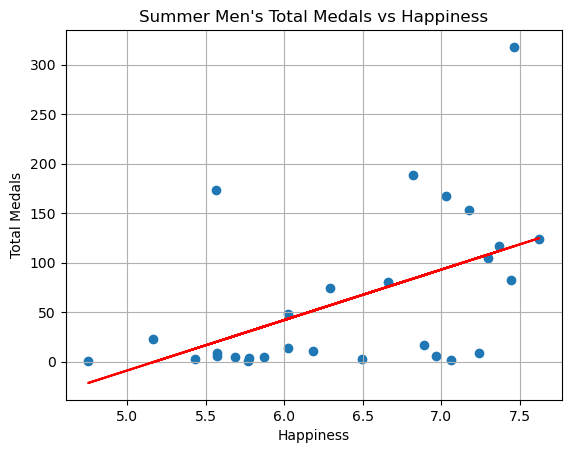

The r-squared is: 0.26642781498362755


In [61]:
scatter_plot_medals(df, 'happiness', 'total_medals', 'Summer Men\'s Total Medals vs Happiness')

In [62]:
# Top and Bottom Mens Winter Games
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='total_medals', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,Norway,318.0,7.463886,11.074348,186487.61,99.5,0.5,5276.968
1,Germany,189.0,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
2,Russia,173.0,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
3,United States,167.0,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
4,Austria,153.0,7.178953,10.889285,197169.69,99.4,0.6,8797.566


,country_name,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
33,New Zealand,2.0,7.260700,10.617803,76140.29,NaN,NaN,4813.600
34,Luxembourg,2.0,7.058734,11.643438,25419.95,99.6,0.4,596.336
35,Ukraine,2.0,4.785123,9.421713,102028.93,NaN,NaN,NaN
36,Romania,1.0,5.770220,10.115109,126545.07,88.1,11.9,19588.715
37,Bulgaria,1.0,4.751980,9.961130,35563.00,88.7,11.3,7075.947


In [64]:
# Alpine Skiing correlation
data_to_select = {
    'discipline_title': 'Alpine Skiing'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
total_medals,1.000000,0.305798,0.331354,0.135036,0.177032,-0.228137,0.067566
happiness,0.305798,1.000000,0.718135,-0.073963,0.737283,-0.749038,-0.254792
wealth,0.331354,0.718135,1.000000,0.068029,0.608131,-0.627043,-0.099482
gdp_avg,0.135036,-0.073963,0.068029,1.000000,-0.085533,0.104610,0.952866
good_diet_pct,0.177032,0.737283,0.608131,-0.085533,1.000000,-1.000000,-0.211721
bad_diet_pct,-0.228137,-0.749038,-0.627043,0.104610,-1.000000,1.000000,0.232156
population,0.067566,-0.254792,-0.099482,0.952866,-0.211721,0.232156,1.000000


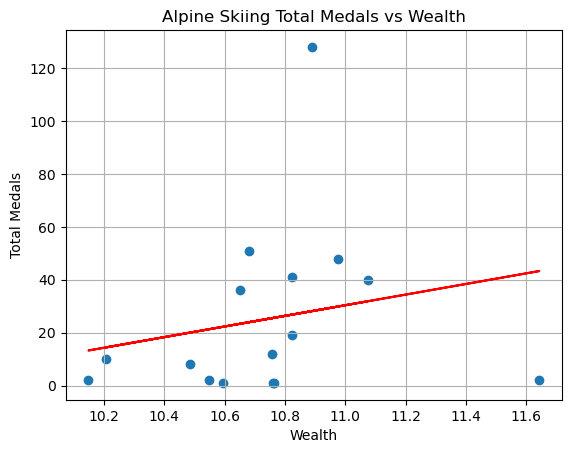

The r-squared is: 0.04394889550430596


In [66]:
scatter_plot_medals(df, 'wealth', 'total_medals', 'Alpine Skiing Total Medals vs Wealth')

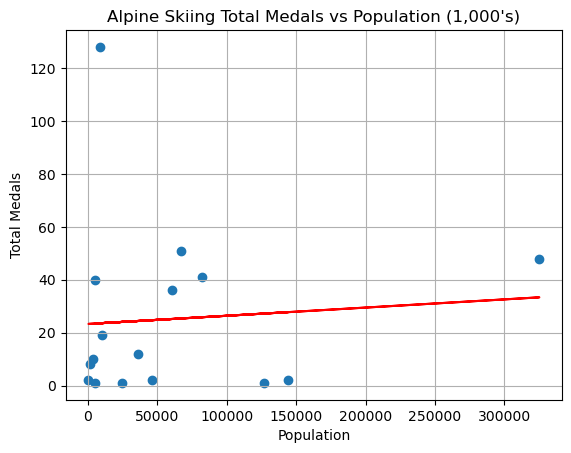

The r-squared is: 0.006144889415580458


In [68]:
scatter_plot_medals(df, 'population', 'total_medals', 'Alpine Skiing Total Medals vs Population (1,000\'s)')

In [71]:
# Top and Bottom Alpine Skiing
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='total_medals', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,United States,821.0,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,Germany,265.0,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
2,Russia,254.0,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
3,Great Britain,211.0,6.889592,10.695583,1345386.44,99.5,0.5,66058.859
4,Finland,114.0,7.624132,10.761079,125374.08,99.9,0.1,5508.214


,country_name,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
92,Côte d'Ivoire,1.0,NaN,NaN,NaN,NaN,NaN,NaN
93,Djibouti,1.0,4.822565,8.053561,1313.37,35.4,64.6,944.100
94,Eritrea,1.0,NaN,NaN,977.77,NaN,NaN,NaN
95,Iran,1.0,4.875571,9.590507,NaN,NaN,NaN,NaN
96,Zambia,1.0,4.365957,8.058288,8339.74,12.4,87.6,16853.608


In [72]:
# Athletics correlation
data_to_select = {
    'discipline_title': 'Athletics'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
total_medals,1.000000,0.225750,0.213940,0.853669,0.201597,-0.190929,0.136839
happiness,0.225750,1.000000,0.828379,0.216188,0.788991,-0.790918,-0.142476
wealth,0.213940,0.828379,1.000000,0.220412,0.902348,-0.903651,-0.124657
gdp_avg,0.853669,0.216188,0.220412,1.000000,0.235302,-0.226407,0.414933
good_diet_pct,0.201597,0.788991,0.902348,0.235302,1.000000,-1.000000,-0.096980
bad_diet_pct,-0.190929,-0.790918,-0.903651,-0.226407,-1.000000,1.000000,0.103415
population,0.136839,-0.142476,-0.124657,0.414933,-0.096980,0.103415,1.000000


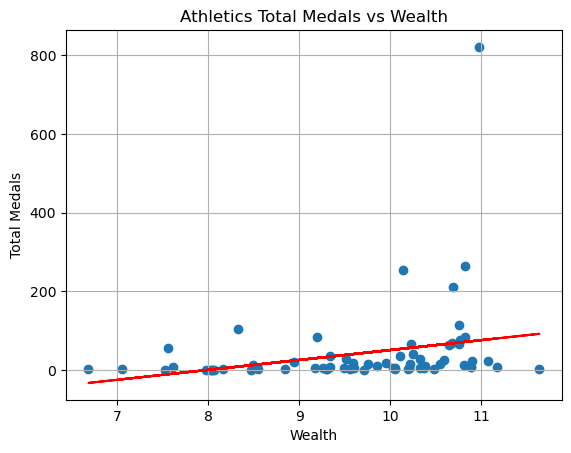

The r-squared is: 0.06649094142861722


In [73]:
scatter_plot_medals(df, 'wealth', 'total_medals', 'Athletics Total Medals vs Wealth')

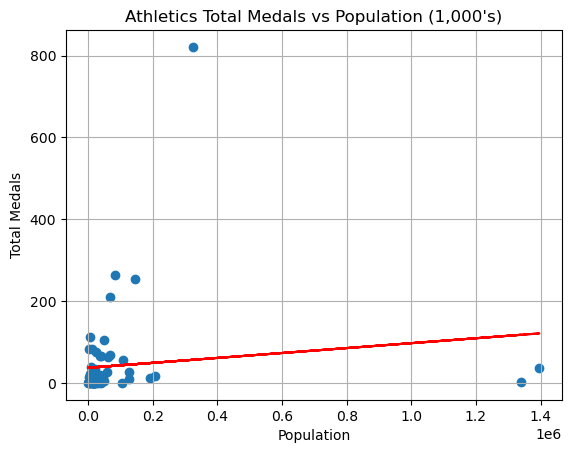

The r-squared is: 0.016266038603577775


In [74]:
scatter_plot_medals(df, 'population', 'total_medals', 'Athletics Total Medals vs Population (1,000\'s)')

In [75]:
# Top and Bottom Athletics
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='total_medals', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,United States,821.0,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,Germany,265.0,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
2,Russia,254.0,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
3,Great Britain,211.0,6.889592,10.695583,1345386.44,99.5,0.5,66058.859
4,Finland,114.0,7.624132,10.761079,125374.08,99.9,0.1,5508.214


,country_name,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
92,Côte d'Ivoire,1.0,NaN,NaN,NaN,NaN,NaN,NaN
93,Djibouti,1.0,4.822565,8.053561,1313.37,35.4,64.6,944.100
94,Eritrea,1.0,NaN,NaN,977.77,NaN,NaN,NaN
95,Iran,1.0,4.875571,9.590507,NaN,NaN,NaN,NaN
96,Zambia,1.0,4.365957,8.058288,8339.74,12.4,87.6,16853.608


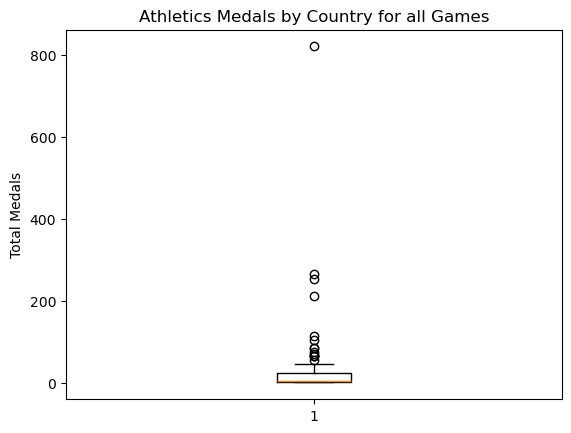

In [21]:
box_plot_medals(df, 'Athletics Medals by Country for all Games')

In [76]:
# Equestrian correlation
data_to_select = {
    'discipline_title': 'Equestrian'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
total_medals,1.000000,0.310986,0.377689,0.492701,0.279537,-0.287216,0.342521
happiness,0.310986,1.000000,0.683807,0.071682,0.323282,-0.340170,-0.065810
wealth,0.377689,0.683807,1.000000,0.169965,0.781323,-0.779723,-0.214912
gdp_avg,0.492701,0.071682,0.169965,1.000000,0.073811,-0.063985,0.857527
good_diet_pct,0.279537,0.323282,0.781323,0.073811,1.000000,-1.000000,-0.318655
bad_diet_pct,-0.287216,-0.340170,-0.779723,-0.063985,-1.000000,1.000000,0.328668
population,0.342521,-0.065810,-0.214912,0.857527,-0.318655,0.328668,1.000000


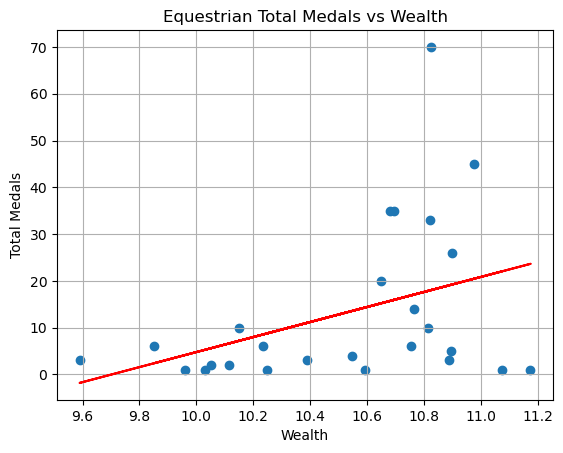

The r-squared is: 0.14936197210588106


In [77]:
scatter_plot_medals(df, 'wealth', 'total_medals', 'Equestrian Total Medals vs Wealth')

In [78]:
# Men's Marathon correlation
data_to_select = {
    'event_title': 'marathon men'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
total_medals,1.000000,-0.043580,-0.125134,0.577848,-0.278441,0.278441,0.548396
happiness,-0.043580,1.000000,0.852334,0.256381,0.793354,-0.793354,0.018815
wealth,-0.125134,0.852334,1.000000,0.267888,0.909755,-0.909755,-0.025087
gdp_avg,0.577848,0.256381,0.267888,1.000000,0.232091,-0.232091,0.849926
good_diet_pct,-0.278441,0.793354,0.909755,0.232091,1.000000,-1.000000,-0.028346
bad_diet_pct,0.278441,-0.793354,-0.909755,-0.232091,-1.000000,1.000000,0.028346
population,0.548396,0.018815,-0.025087,0.849926,-0.028346,0.028346,1.000000


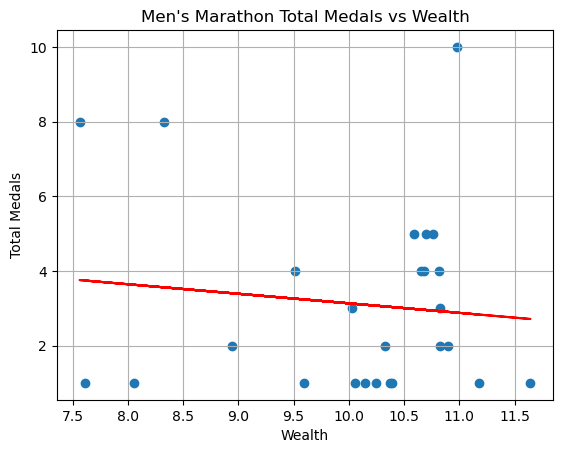

The r-squared is: 0.012465761689657727


In [79]:
scatter_plot_medals(df, 'wealth', 'total_medals', 'Men\'s Marathon Total Medals vs Wealth')

In [80]:
# Women's Marathon correlation
data_to_select = {
    'event_title': 'marathon women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,total_medals,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
total_medals,1.000000,-0.570206,-0.552147,0.084840,-0.664974,0.664974,-0.140861
happiness,-0.570206,1.000000,0.875518,0.231960,0.775235,-0.775235,-0.241544
wealth,-0.552147,0.875518,1.000000,0.256778,0.940345,-0.940345,-0.208211
gdp_avg,0.084840,0.231960,0.256778,1.000000,0.318468,-0.318468,0.434336
good_diet_pct,-0.664974,0.775235,0.940345,0.318468,1.000000,-1.000000,0.060357
bad_diet_pct,0.664974,-0.775235,-0.940345,-0.318468,-1.000000,1.000000,-0.060357
population,-0.140861,-0.241544,-0.208211,0.434336,0.060357,-0.060357,1.000000


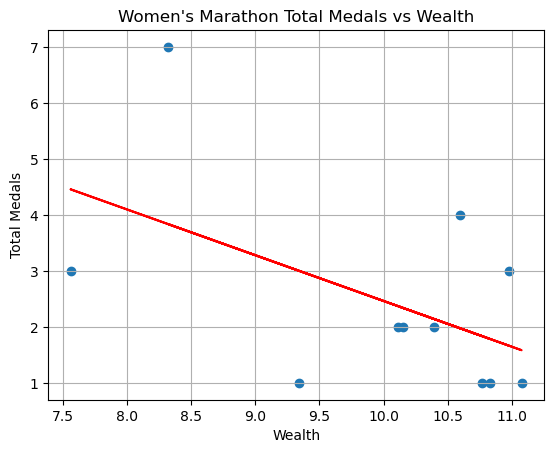

The r-squared is: 0.2676879756673039


In [81]:
scatter_plot_medals(df, 'wealth', 'total_medals', 'Women\'s Marathon Total Medals vs Wealth')

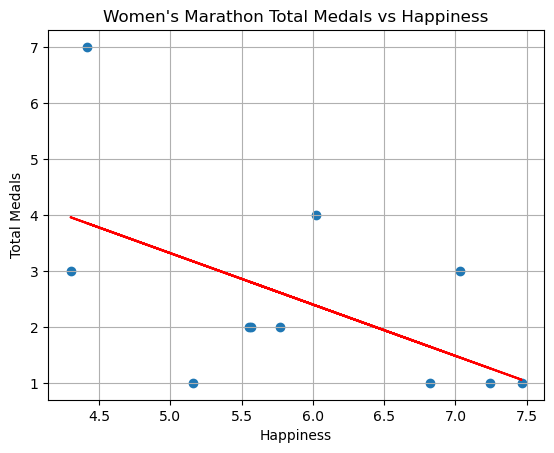

The r-squared is: 0.3066557859883721


In [82]:
scatter_plot_medals(df, 'happiness', 'total_medals', 'Women\'s Marathon Total Medals vs Happiness')

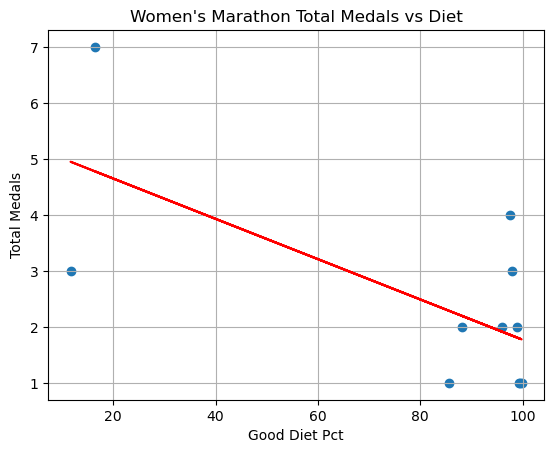

The r-squared is: 0.4421898246604356


In [83]:
scatter_plot_medals(df, 'good_diet_pct', 'total_medals', 'Women\'s Marathon Total Medals vs Diet')